# Babi6 Generator

In [54]:
import pickle
from tqdm import trange, tqdm
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np

from lambeq import CachedTnPathOptimizer, PytorchTrainer

from utils.babi6.vocabulary import (
    PEOPLE, LOCATIONS, OBJECTS, MOVE, GRAB, DROP
)
from utils.babi6.generate_babi_stories import generate, Answers
from utils.babi6.parse_babi import bAbI6Parser, babiSandwichFunctor
from utils.ansatz import DiscardSim4Ansatz
from utils.training import QADataset, PytorchQAModel

SAVE_DIR = Path("./results/babi6").resolve()
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_DIR

PosixPath('/Users/tiffany.duneau/PycharmProjects/QDisCoCirc_Following_Showcase/tutorials/results/babi6')

In [23]:
generate(PEOPLE, OBJECTS, LOCATIONS, MOVE, GRAB, DROP, depth=1, max_nouns=None)

((['Eric went to the bedroom.'], 'Is Eric in the bedroom?\tyes\t0', 'yes'),
 WorldState(people=['Eric'], objects=[], locations=['bedroom'], state={'Eric': In bedroom with set() ([0])}))

In [24]:
min_depth = 2
max_depth = 11
depth_step = 2
samples_per_shape = 8

In [41]:
# Define the story depths to target
all_shapes = [
    (depth, ans_class.value)
    for depth in range(min_depth, max_depth, depth_step)
    for ans_class in Answers
]

data = {shape: [] for shape in all_shapes}
finished_shapes = []

# Configurable:
def get_shape(world_state, story):
    return len(story[0]), story[2]

data.keys()

dict_keys([(2, 'yes'), (2, 'no'), (4, 'yes'), (4, 'no'), (6, 'yes'), (6, 'no'), (8, 'yes'), (8, 'no'), (10, 'yes'), (10, 'no')])

In [42]:
# For systematicity, we restrict the available people and locations, such that interactions between groups are limited.
ONE_PERSON = PEOPLE[:1]
_ONE_PERSON = PEOPLE[1:]
ONE_LOCATION = LOCATIONS[:1]
_ONE_LOCATION = LOCATIONS[1:]

In [44]:
# Attempt to generate the requested shapes
for depth in trange(min_depth, max_depth, depth_step, desc="Generating stories"):
    attempts = 0
    while len(finished_shapes) != len(all_shapes) and attempts < 300:
        attempts += 1
        try:
            story, world_state = generate(
                PEOPLE, OBJECTS, LOCATIONS, MOVE, GRAB, DROP,
                depth=depth, max_nouns=None
            )
            shape = get_shape(world_state, story)

            if shape in all_shapes and shape not in finished_shapes:
                if story not in data[shape]:
                    data[shape].append((story, world_state))
                    if len(data[shape]) == samples_per_shape:
                        finished_shapes.append(shape)
            else:
                continue
        except Exception as e:
            pass

# write to file
with open(SAVE_DIR / "stories.pkl", "wb") as f:
    pickle.dump(data, f)

data.keys(), f"missing {len(all_shapes) - len(finished_shapes)}"


Generating stories: 100%|██████████| 5/5 [00:00<00:00, 69672.82it/s]


(dict_keys([(2, 'yes'), (2, 'no'), (4, 'yes'), (4, 'no'), (6, 'yes'), (6, 'no'), (8, 'yes'), (8, 'no'), (10, 'yes'), (10, 'no')]),
 'missing 0')

In [45]:
# User ansatz params
n_qb_per_noun = 1
n_layers = 3

In [46]:
# Define the ansatz
parser = bAbI6Parser()
ansatz = DiscardSim4Ansatz(
    ob_map={parser.n: n_qb_per_noun},
    n_layers=n_layers,
    discard=True,
    n_ancillas=0,
)

In [48]:
def convert(story, question, answer_class, world_state):
    person = question.split(" ")[1]
    location = question.split(" ")[4].split("?")[0]
    context_diag = parser.babi_text_to_diagram(
        " ".join(story) + " ",  # Parser expects as a joined string.
        person, location
    )
    yes_question = parser.babi_question_to_diagram(question, positive=True)
    no_question = parser.babi_question_to_diagram(question, positive=False)

    context_sandwich = babiSandwichFunctor(context_diag)
    yes_sandwich = babiSandwichFunctor(yes_question)
    no_sandwich = babiSandwichFunctor(no_question)

    context_circ = ansatz(context_sandwich)
    yes_circ = context_circ >> ansatz(yes_sandwich).dagger()
    no_circ = context_circ >> ansatz(no_sandwich).dagger()

    return {
        "story": story,
        "n_nouns": world_state.get_n_nouns(),
        "n_sentences": len(story),
        "question_nouns": (person, location),
        "answer_class": answer_class,
        "diags": (context_diag, yes_question, no_question),
        "sandwiched": (
            context_sandwich >> yes_sandwich.dagger(),
            context_sandwich >> no_sandwich.dagger()
        ),
        "circuits": (yes_circ, no_circ),
        "target": torch.tensor([1, 0] if answer_class == "yes" else [0, 1], dtype=torch.float32)
    }

dataset = [
    convert(*story, world_state)
    for k in tqdm(data.keys())
    for story, world_state in data[k]
]

with open(SAVE_DIR / "circuits.pkl", "wb") as f:
    pickle.dump(dataset, f)

len(dataset)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:00,  9.12it/s]

 30%|███       | 3/10 [00:00<00:00,  8.56it/s]

 40%|████      | 4/10 [00:00<00:00,  7.57it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.52it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.69it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.44it/s]

  0%|          | 0/10 [13:43<?, ?it/s].89it/s]


 90%|█████████ | 9/10 [00:04<00:00,  1.06it/s]

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


80

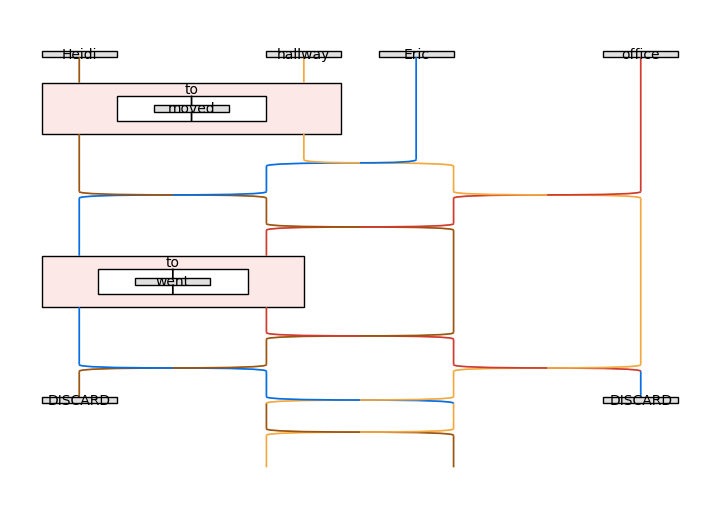

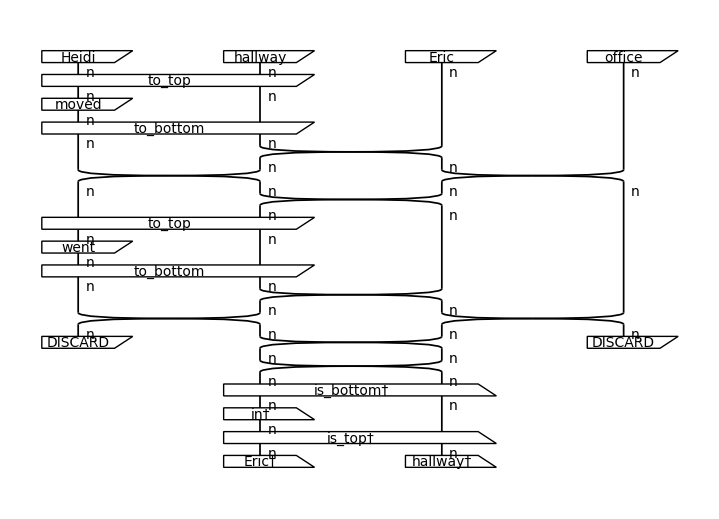

[Eric__n_0, Eric__n_1, Eric__n_2, Heidi__n_0, Heidi__n_1, Heidi__n_2, hallway__n_0, hallway__n_1, hallway__n_2, in_n_n_0, in_n_n_1, in_n_n_2, is_bottom_n@n_n@n_0, is_bottom_n@n_n@n_1, is_bottom_n@n_n@n_10, is_bottom_n@n_n@n_11, is_bottom_n@n_n@n_12, is_bottom_n@n_n@n_13, is_bottom_n@n_n@n_14, is_bottom_n@n_n@n_2, is_bottom_n@n_n@n_3, is_bottom_n@n_n@n_4, is_bottom_n@n_n@n_5, is_bottom_n@n_n@n_6, is_bottom_n@n_n@n_7, is_bottom_n@n_n@n_8, is_bottom_n@n_n@n_9, is_top_n@n_n@n_0, is_top_n@n_n@n_1, is_top_n@n_n@n_10, is_top_n@n_n@n_11, is_top_n@n_n@n_12, is_top_n@n_n@n_13, is_top_n@n_n@n_14, is_top_n@n_n@n_2, is_top_n@n_n@n_3, is_top_n@n_n@n_4, is_top_n@n_n@n_5, is_top_n@n_n@n_6, is_top_n@n_n@n_7, is_top_n@n_n@n_8, is_top_n@n_n@n_9, moved_n_n_0, moved_n_n_1, moved_n_n_2, office__n_0, office__n_1, office__n_2, to_bottom_n@n_n@n_0, to_bottom_n@n_n@n_1, to_bottom_n@n_n@n_10, to_bottom_n@n_n@n_11, to_bottom_n@n_n@n_12, to_bottom_n@n_n@n_13, to_bottom_n@n_n@n_14, to_bottom_n@n_n@n_2, to_bottom_n@

(['Heidi moved to the hallway.', 'Eric went to the office.'],
 4,
 2,
 ('Eric', 'hallway'),
 'no')

In [49]:
# Inspect the generated circuits.

inspect_index = 10
dataset[inspect_index]["diags"][0].draw(figsize=(7, 5))
dataset[inspect_index]["sandwiched"][0].draw(figsize=(7, 5))
print(sorted(dataset[inspect_index]["circuits"][0].free_symbols))
(
    dataset[inspect_index]["story"],
    dataset[inspect_index]["n_nouns"],
    dataset[inspect_index]["n_sentences"],
    dataset[inspect_index]["question_nouns"],
    dataset[inspect_index]["answer_class"],
)

# Data split

In [64]:
# User params
batch_size = 1

train_size = 0.5
valid_size = 0.75

n_actor_train_cutoff = 8
n_actor_valid_cutoff = 12

In [65]:
train_threshold = min_depth + train_size * (max_depth - min_depth)
valid_threshold = min_depth + valid_size * (max_depth - min_depth)

train_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] < train_threshold and entry["n_nouns"] < n_actor_train_cutoff
]
valid_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] >= train_threshold and entry["n_nouns"] >= n_actor_train_cutoff
    and entry["n_sentences"] < valid_threshold and entry["n_nouns"] < n_actor_valid_cutoff
]
test_ids = [
    i for i, entry in enumerate(dataset)
    if entry["n_sentences"] >= valid_threshold and entry["n_nouns"] >= n_actor_valid_cutoff
]
other_ids = [
    i for i in range(len(dataset))
    if i not in train_ids + valid_ids + test_ids
]

train_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in train_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in train_ids],
    batch_size=batch_size, shuffle=True
)
valid_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in valid_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in valid_ids],
    batch_size=0, shuffle=False
)
test_dataset = QADataset(
    data=[entry["circuits"] for i, entry in enumerate(dataset) if i in test_ids],
    targets=[entry["target"] for i, entry in enumerate(dataset) if i in test_ids],
    batch_size=0, shuffle=False
)

len(train_dataset), len(valid_dataset), len(test_dataset), len(other_ids)

(26, 4, 14, 36)

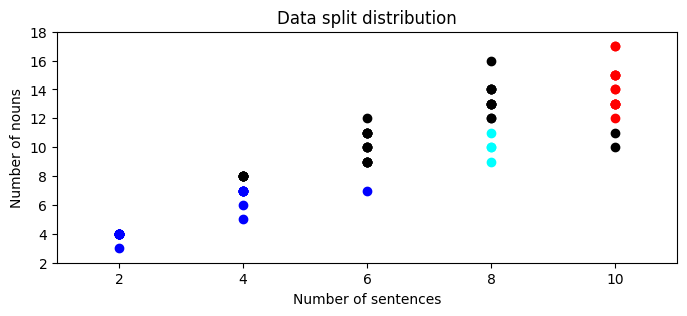

In [66]:
# Visualise the data split distribution
fig, ax = plt.subplots(figsize=(8,3))
ax.set_title('Data split distribution')
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Number of nouns')

widths = [entry["n_nouns"] for entry in dataset]
depths = [entry["n_sentences"] for entry in dataset]
ax.set_xlim(min(depths)-1, max(depths)+1)
ax.set_ylim(min(widths)-1, max(widths)+1)


for ids, col in zip([train_ids, valid_ids, test_ids, other_ids], ["blue", "cyan", "red", "black"]):
    ax.scatter(
        x=[entry["n_sentences"] for i, entry in enumerate(dataset) if i in ids],
        y=[entry["n_nouns"] for i, entry in enumerate(dataset) if i in ids],
        c=col
    )

### Training

In [67]:
n_epochs = 40
learning_rate = 5e-3
training_seed = 420

In [68]:
def acc(batched_y_hat: torch.tensor, batched_y: torch.tensor) -> torch.tensor:
    argmax_y_hat = torch.argmax(batched_y_hat, dim=1)
    argmax_y = torch.argmax(batched_y, dim=1)
    accs = argmax_y_hat == argmax_y
    return torch.mean(accs, dtype=torch.float)

In [69]:
model = PytorchQAModel.from_diagrams(
    diagrams=train_dataset.data + valid_dataset.data + test_dataset.data,
    tn_path_optimizer=CachedTnPathOptimizer(save_file=Path(SAVE_DIR / "tn_cache.pkl"))
)
model.initialise_weights()

trainer = PytorchTrainer(
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    epochs=n_epochs,
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": learning_rate},
    evaluate_functions={"acc": acc},
    evaluate_on_train=True,
    seed=training_seed,
    verbose='text',
    log_dir=Path(SAVE_DIR / "training"),
)
print(f"{model.state_dict()['weights'].numel()} parameters")

393 parameters


In [ ]:
trainer.fit(
    train_dataset=train_dataset,
    val_dataset=valid_dataset,
    log_interval=1,
    eval_interval=1,
    minimize_criterion=True,
)

  0%|          | 0/10 [07:14<?, ?it/s]


### Results

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(
    2, 2, sharex=True, sharey='row', figsize=(10, 6)
)
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color="blue")
ax_bl.plot(range_, trainer.train_eval_results['acc'], color="blue")
ax_tr.plot(range_, trainer.val_costs, color="cyan")
ax_br.plot(range_, trainer.val_eval_results['acc'], color="cyan")